In [1]:
#imports

%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
import time

In [2]:
#changes are required only in this section when we need to change the directory of training and test data set:
train_dir = "dummy/train"
test_dir = "dummy/test"


#if we want to change the model here we can do it.
model = VGG16(include_top=True, weights='imagenet')

In [3]:
#helper functions
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [4]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [5]:
#plot incorrect prediction images
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
    
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)
    
#function for plotting training history 
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [6]:
#to check image shape input
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [7]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

datagen_test = ImageDataGenerator(rescale=1./255)
batch_size = 10

In [8]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

In [9]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 12 images belonging to 3 classes.


In [10]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 12 images belonging to 3 classes.


In [11]:
steps_test = generator_test.n / batch_size
steps_test
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)
cls_train = generator_train.classes
cls_test = generator_test.classes
class_names = list(generator_train.class_indices.keys())
class_names
num_classes = generator_train.num_classes
num_classes

3

C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (110031264 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (127420950 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (109120382 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (106229802 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (115144605 

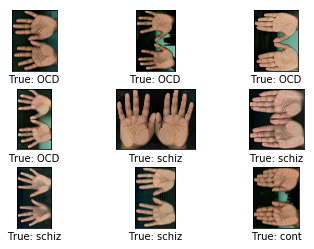

In [12]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [13]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)
class_weight

array([1., 1., 1.])

In [14]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (110031264 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


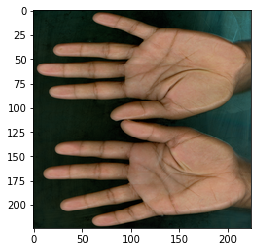

28.73% : hair_slide
14.31% : bath_towel
 8.28% : bow_tie
 5.60% : mitten
 4.69% : daisy


In [15]:
predict(image_path=image_paths_train[0])

C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (127420950 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


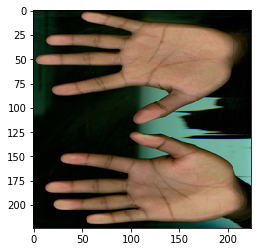

47.67% : daisy
 3.22% : hair_slide
 2.81% : bath_towel
 1.96% : bee
 1.67% : safety_pin


In [16]:
predict(image_path=image_paths_train[1])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
transfer_layer = model.get_layer('block5_pool')
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [19]:
optimizer = Adam(lr=1e-5)
#We have 3 classes in the so Keras needs to use this loss-function.

loss = 'categorical_crossentropy'
#The only performance metric we are interested in is the classification accuracy.

metrics = ['categorical_accuracy']

#Helper-function for printing whether a layer in the VGG16 model should be trained.


def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [20]:
#By default all the layers of the VGG16 model are trainable.

print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [24]:
#In Transfer Learning we are initially only interested in reusing the pre-trained VGG16 model as it is, so we will disable training for all its layers.

conv_model.trainable = False

for layer in conv_model.layers:
    layer.trainable = False

print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [25]:
#Once we have changed whether the model's layers are trainable, we need to compile the model for the changes to take effect.

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
"""
An epoch normally means one full processing of the training-set. 
But the data-generator that we created above, will produce batches of training-data for eternity. 
So we need to define the number of steps we want to run for each "epoch" and this number gets multiplied by the batch-size 
defined above. In this case we have 100 steps per epoch and a batch-size of 20, so the "epoch" consists of 2000 random images 
from the training-set. We run 20 such "epochs".

The reason these particular numbers were chosen, was because they seemed to be sufficient for training with this particular model
and dataset, and it didn't take too much time, and resulted in 20 data-points (one for each "epoch") which can be plotted 
afterwards.
"""
epochs = 2
steps_per_epoch = 10

In [26]:
#Training the new model is just a single function call in the Keras API. This takes about 6-7 minutes on a GTX 1070 GPU.

name = "vgg16-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(name))

history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test, callbacks=[tensorboard])

Epoch 1/2


C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (97552517 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (127420950 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (109120382 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (110031264 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (99828225 pi

10/10 [==============================] - 561s 56s/step - loss: 1.2560 - categorical_accuracy: 0.3682 - val_loss: 1.2717 - val_categorical_accuracy: 0.2500
Epoch 2/2
10/10 [==============================] - 497s 50s/step - loss: 1.1654 - categorical_accuracy: 0.3682 - val_loss: 1.1599 - val_categorical_accuracy: 0.4167


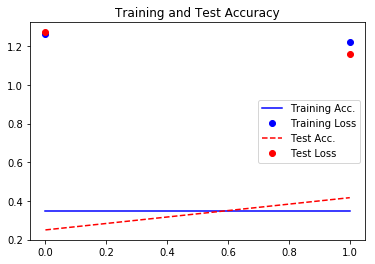

In [27]:
plot_training_history(history)

C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (110031264 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (127420950 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (109120382 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (106229802 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (115144605 

Test-set classification accuracy: 41.67%


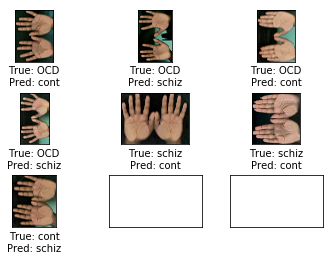

Confusion matrix:
[[0 2 2]
 [0 2 2]
 [0 1 3]]
(0) OCD
(1) schiz
(2) cont


In [28]:
#After training we can also evaluate the new model's performance on the test-set using a single function call in the Keras API.

result = new_model.evaluate_generator(generator_test, steps=steps_test)

print("Test-set classification accuracy: {0:.2%}".format(result[1]))

#plot some examples of mis-classified images from the test-set. 
#The confusion matrix shows that the new model is especially having problems classifying the forky-class.

example_errors()

In [29]:
"""
It is a bit unclear whether Keras uses the trainable boolean in each layer of the original VGG16 model or if it is overrided by 
the trainable boolean in the "meta-layer" we call conv_layer. So we will enable the trainable boolean for both conv_layer and 
all the relevant layers in the original VGG16 model.
"""

conv_model.trainable = True

#We want to train the last 3 convolutional layers whose names contain 'block5' or 'block4' or 'block3'.


for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name or 'block3' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

#We can check that this has updated the trainable boolean for the relevant layers.

print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [30]:
#We will use a lower learning-rate for the fine-tuning so the weights of the original VGG16 model only get changed slowly.
optimizer_fine = Adam(lr=1e-7)

In [31]:
#Because we have defined a new optimizer and have changed the trainable boolean for many of the layers in the model, 
#we need to recompile the model so the changes can take effect before we continue training.

new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

#The training continued so as to fine-tune the VGG16 model along with the new classifier.


tensorboard = TensorBoard(log_dir='logs/{}'.format(name))
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test, callbacks=[tensorboard])

Epoch 1/2


C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (110031264 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (115581609 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (127420950 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (115144605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (99828225 p

10/10 [==============================] - 744s 74s/step - loss: 1.1911 - categorical_accuracy: 0.3576 - val_loss: 1.1607 - val_categorical_accuracy: 0.4167
Epoch 2/2
10/10 [==============================] - 663s 66s/step - loss: 1.3765 - categorical_accuracy: 0.2742 - val_loss: 1.1601 - val_categorical_accuracy: 0.4167


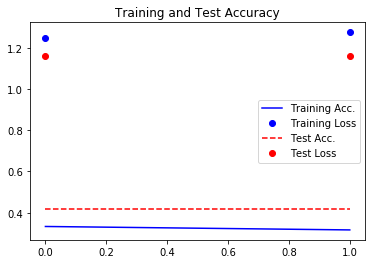

In [32]:
plot_training_history(history)

In [33]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

print("Test-set classification accuracy: {0:.2%}".format(result[1]))

C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (110031264 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (127420950 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (109120382 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (106229802 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (115144605 

Test-set classification accuracy: 41.67%


C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (110031264 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (127420950 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (109120382 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (106229802 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\Rimjhim\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (115144605 

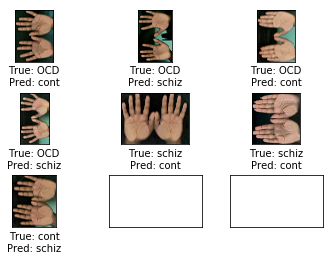

Confusion matrix:
[[0 2 2]
 [0 2 2]
 [0 1 3]]
(0) OCD
(1) schiz
(2) cont


In [34]:
example_errors()